<a href="https://colab.research.google.com/github/AnaBeatrizMassuh/TP7_PLN/blob/main/Atividade_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras
!pip install tensorflow
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
ds_train = tfds.load('snli', split = 'train[50%:]', shuffle_files = True)
ds_valid = tfds.load('snli', split = 'validation', shuffle_files = False)
ds_test = tfds.load('snli', split = 'test', shuffle_files = False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete90PEUI/snli-test.tfrecord*...:   0%|          | 0/10000 […

Generating validation examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete90PEUI/snli-validation.tfrecord*...:   0%|          | 0/1…

Generating train examples...:   0%|          | 0/550152 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete90PEUI/snli-train.tfrecord*...:   0%|          | 0/550152…

Dataset snli downloaded and prepared to ~/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


In [4]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [5]:
print(f'Train size {df_train.shape}')
print(f'Valid size {df_valid.shape}')
print(f'Test size {df_test.shape}')

Train size (275076, 3)
Valid size (10000, 3)
Test size (10000, 3)


In [6]:
df_train.head()

,hypothesis,label,premise
0,b'A child reaches up.',0,b'a child reaches up into the air as a woman s...
1,b'A person with a backpack',0,b'A young woman wearing a backpack takes the b...
2,b'A man holding a hard hat is running.',0,b'A man holding a hard hat runs across a street.'
3,b'A female in weird clothing holding a glass.',0,"b'Woman wearing a costume, drinking a beverage.'"
4,b'There are bikers.',0,b'A group of bikers head out the gates in a Lo...


In [7]:
df_train['text'] = df_train['hypothesis'].str.decode(encoding='UTF-8') + " " + df_train['premise'].str.decode(encoding='UTF-8')
df_valid['text'] = df_valid['hypothesis'].str.decode(encoding='UTF-8') + " " + df_valid['premise'].str.decode(encoding='UTF-8')
df_test['text'] = df_test['hypothesis'].str.decode(encoding='UTF-8') + " " + df_test['premise'].str.decode(encoding='UTF-8')

In [8]:
df_train.head()

,hypothesis,label,premise,text
0,b'A child reaches up.',0,b'a child reaches up into the air as a woman s...,A child reaches up. a child reaches up into th...
1,b'A person with a backpack',0,b'A young woman wearing a backpack takes the b...,A person with a backpack A young woman wearing...
2,b'A man holding a hard hat is running.',0,b'A man holding a hard hat runs across a street.',A man holding a hard hat is running. A man hol...
3,b'A female in weird clothing holding a glass.',0,"b'Woman wearing a costume, drinking a beverage.'",A female in weird clothing holding a glass. Wo...
4,b'There are bikers.',0,b'A group of bikers head out the gates in a Lo...,There are bikers. A group of bikers head out t...


Geração dos Logits dos labels utilizando a função to_categorical do Tensorflow:

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,MaxPooling1D,Activation,Flatten
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report

In [10]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [11]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

#Numericalização

In [12]:
train_data = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_data)):
    train_data[i] = train_data[i].lower()
    for word in train_data[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [13]:
vocab_size = len(vocabulary)

In [14]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['text'])

In [15]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])

In [16]:
print(f"Tweet: {df_train['text'][0]}")
print('Tweet numericalizado: ')
print(train_sequences[0])
print(f'Quantidade de palavras no tweet: {len(train_sequences[0])}')

Tweet: A child reaches up. a child reaches up into the air as a woman stands to his left and another person is seen wearing jeans to his right
Tweet numericalizado: 
[1, 44, 1211, 51, 1, 44, 1211, 51, 72, 2, 129, 54, 1, 11, 86, 14, 18, 391, 7, 80, 40, 4, 782, 16, 154, 14, 18, 394]
Quantidade de palavras no tweet: 28


#Pós-processamento da numericalização

In [17]:
max_words = 70

hist = {}

hist['qtde'] = [x for x in range(0, max_words)]

lista = [0]*(max_words)
for x in train_sequences:
  lista[len(x)]+=1

hist['num hypothesis'] = lista

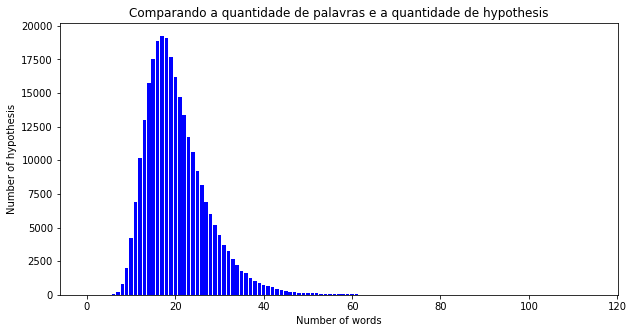

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hist['qtde'],hist['num hypothesis'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of hypothesis")
plt.title("Comparando a quantidade de palavras e a quantidade de hypothesis")
plt.show()

In [19]:
max_length = 50

In [20]:
trunc_type = 'post'
padding_type = 'post'

In [21]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [22]:
print('Tweet:')
print(df_train['text'][0])
print('\nVetor numericalizado da hipotese:')
print(train_sequences[0])
print('\nVetor numericalizado pós-processado com padding e truncamento:')
print(train_padded[0])

Tweet:
A child reaches up. a child reaches up into the air as a woman stands to his left and another person is seen wearing jeans to his right

Vetor numericalizado do tweet:
[1, 44, 1211, 51, 1, 44, 1211, 51, 72, 2, 129, 54, 1, 11, 86, 14, 18, 391, 7, 80, 40, 4, 782, 16, 154, 14, 18, 394]

Vetor numericalizado pós-processado com padding e truncamento:
[   1   44 1211   51    1   44 1211   51   72    2  129   54    1   11
   86   14   18  391    7   80   40    4  782   16  154   14   18  394
    0    0    0    0    0    0    0]


Numericalização dos dados de validação e de testes

In [23]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Arquitetura da Rede Neural Convulacional Profunda (RNCP)

In [24]:
n = 50

In [32]:
from keras.layers import Dense,Activation,Embedding,SimpleRNN,Dropout

model = Sequential()
model.add(Embedding(vocab_size, output_dim = n, input_length=max_length))
model.add(SimpleRNN(64,return_sequences=True,activation='relu'))
model.add(Dropout(0.5))
model.add(SimpleRNN(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 35, 35)            1590785   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 35, 64)            6400      
                                                                 
 dropout_4 (Dropout)         (None, 35, 64)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,600,421
Trainable params: 1,600,421
No

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = n, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=11, strides=1))
model.add(Activation('relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

In [34]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=20)

Epoch 1/20
8597/8597 [==============================] - 199s 23ms/step - loss: 1.1119 - accuracy: 0.3333 - val_loss: 1.1817 - val_accuracy: 0.3349
Epoch 2/20
8597/8597 [==============================] - 189s 22ms/step - loss: 1.1108 - accuracy: 0.3330 - val_loss: 1.1880 - val_accuracy: 0.3235
Epoch 3/20
8597/8597 [==============================] - 183s 21ms/step - loss: 1.1100 - accuracy: 0.3315 - val_loss: 1.1866 - val_accuracy: 0.3278
Epoch 4/20
8597/8597 [==============================] - 182s 21ms/step - loss: 1.1096 - accuracy: 0.3337 - val_loss: 1.1836 - val_accuracy: 0.3329
Epoch 5/20
8597/8597 [==============================] - 188s 22ms/step - loss: 1.1093 - accuracy: 0.3328 - val_loss: 1.1854 - val_accuracy: 0.3235
Epoch 6/20
8597/8597 [==============================] - 195s 23ms/step - loss: 1.1093 - accuracy: 0.3328 - val_loss: 1.1853 - val_accuracy: 0.3329
Epoch 7/20
8597/8597 [==============================] - 187s 22ms/step - loss: 1.1089 - accuracy: 0.3329 - val_loss: 1

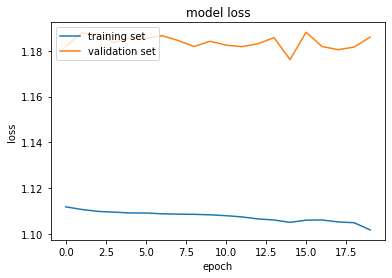

In [35]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

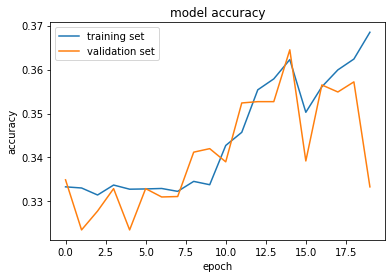

In [36]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [37]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [38]:
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.34      1.00      0.50      3368
           2       0.45      0.00      0.01      3219
           3       0.00      0.00      0.00      3237

    accuracy                           0.34     10000
   macro avg       0.20      0.25      0.13     10000
weighted avg       0.26      0.34      0.17     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
